In [4]:
from ddpm_conditional import *

n = 20
device = "cuda:0"
model = UNet_conditional(num_classes=22, img_width=128, img_height=64).to(device)
ckpt = torch.load("models/CFG_cosine_350steps_settDense/ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_width=128, img_height=64, device=device, noise_steps=350)
y = torch.Tensor([20.,100.,10.5,50.,40.]).to(device)
x = diffusion.sample(model, n, y, cfg_scale=3)

11:01:58 - INFO: Sampling 20 new images....
349it [02:23,  2.43it/s]


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


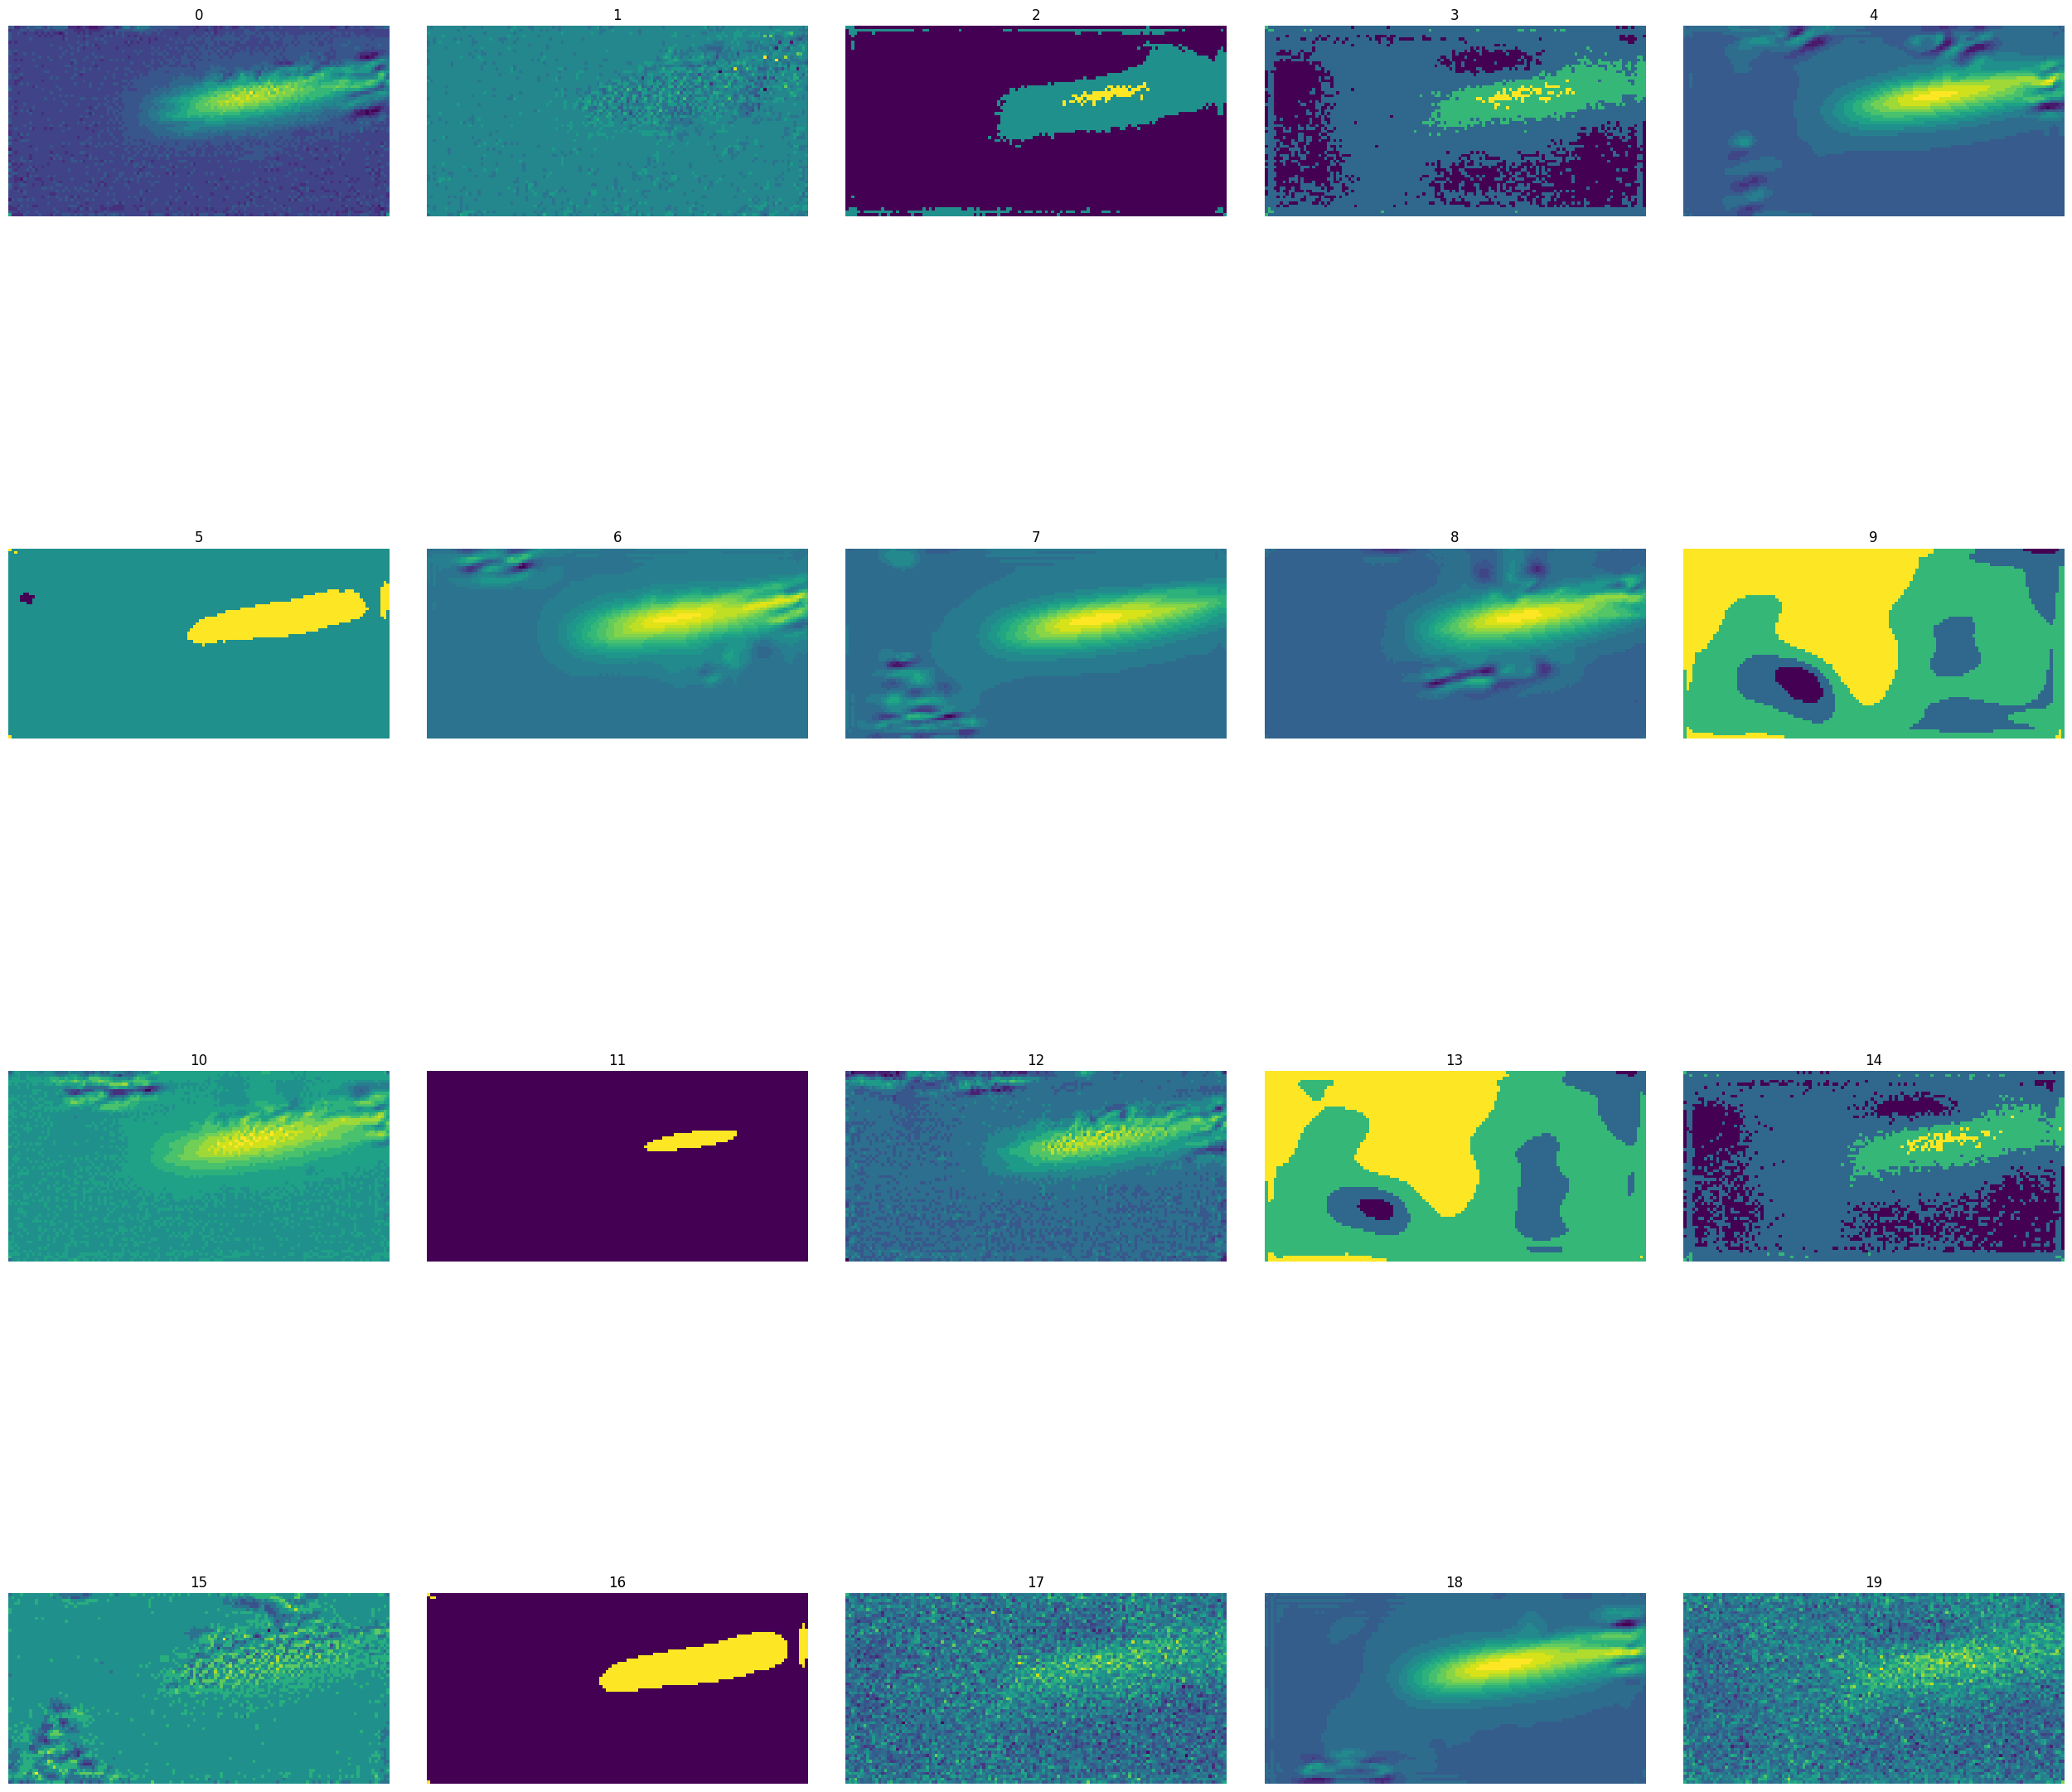

In [6]:
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir
plot_images(x)
save_samples(x)

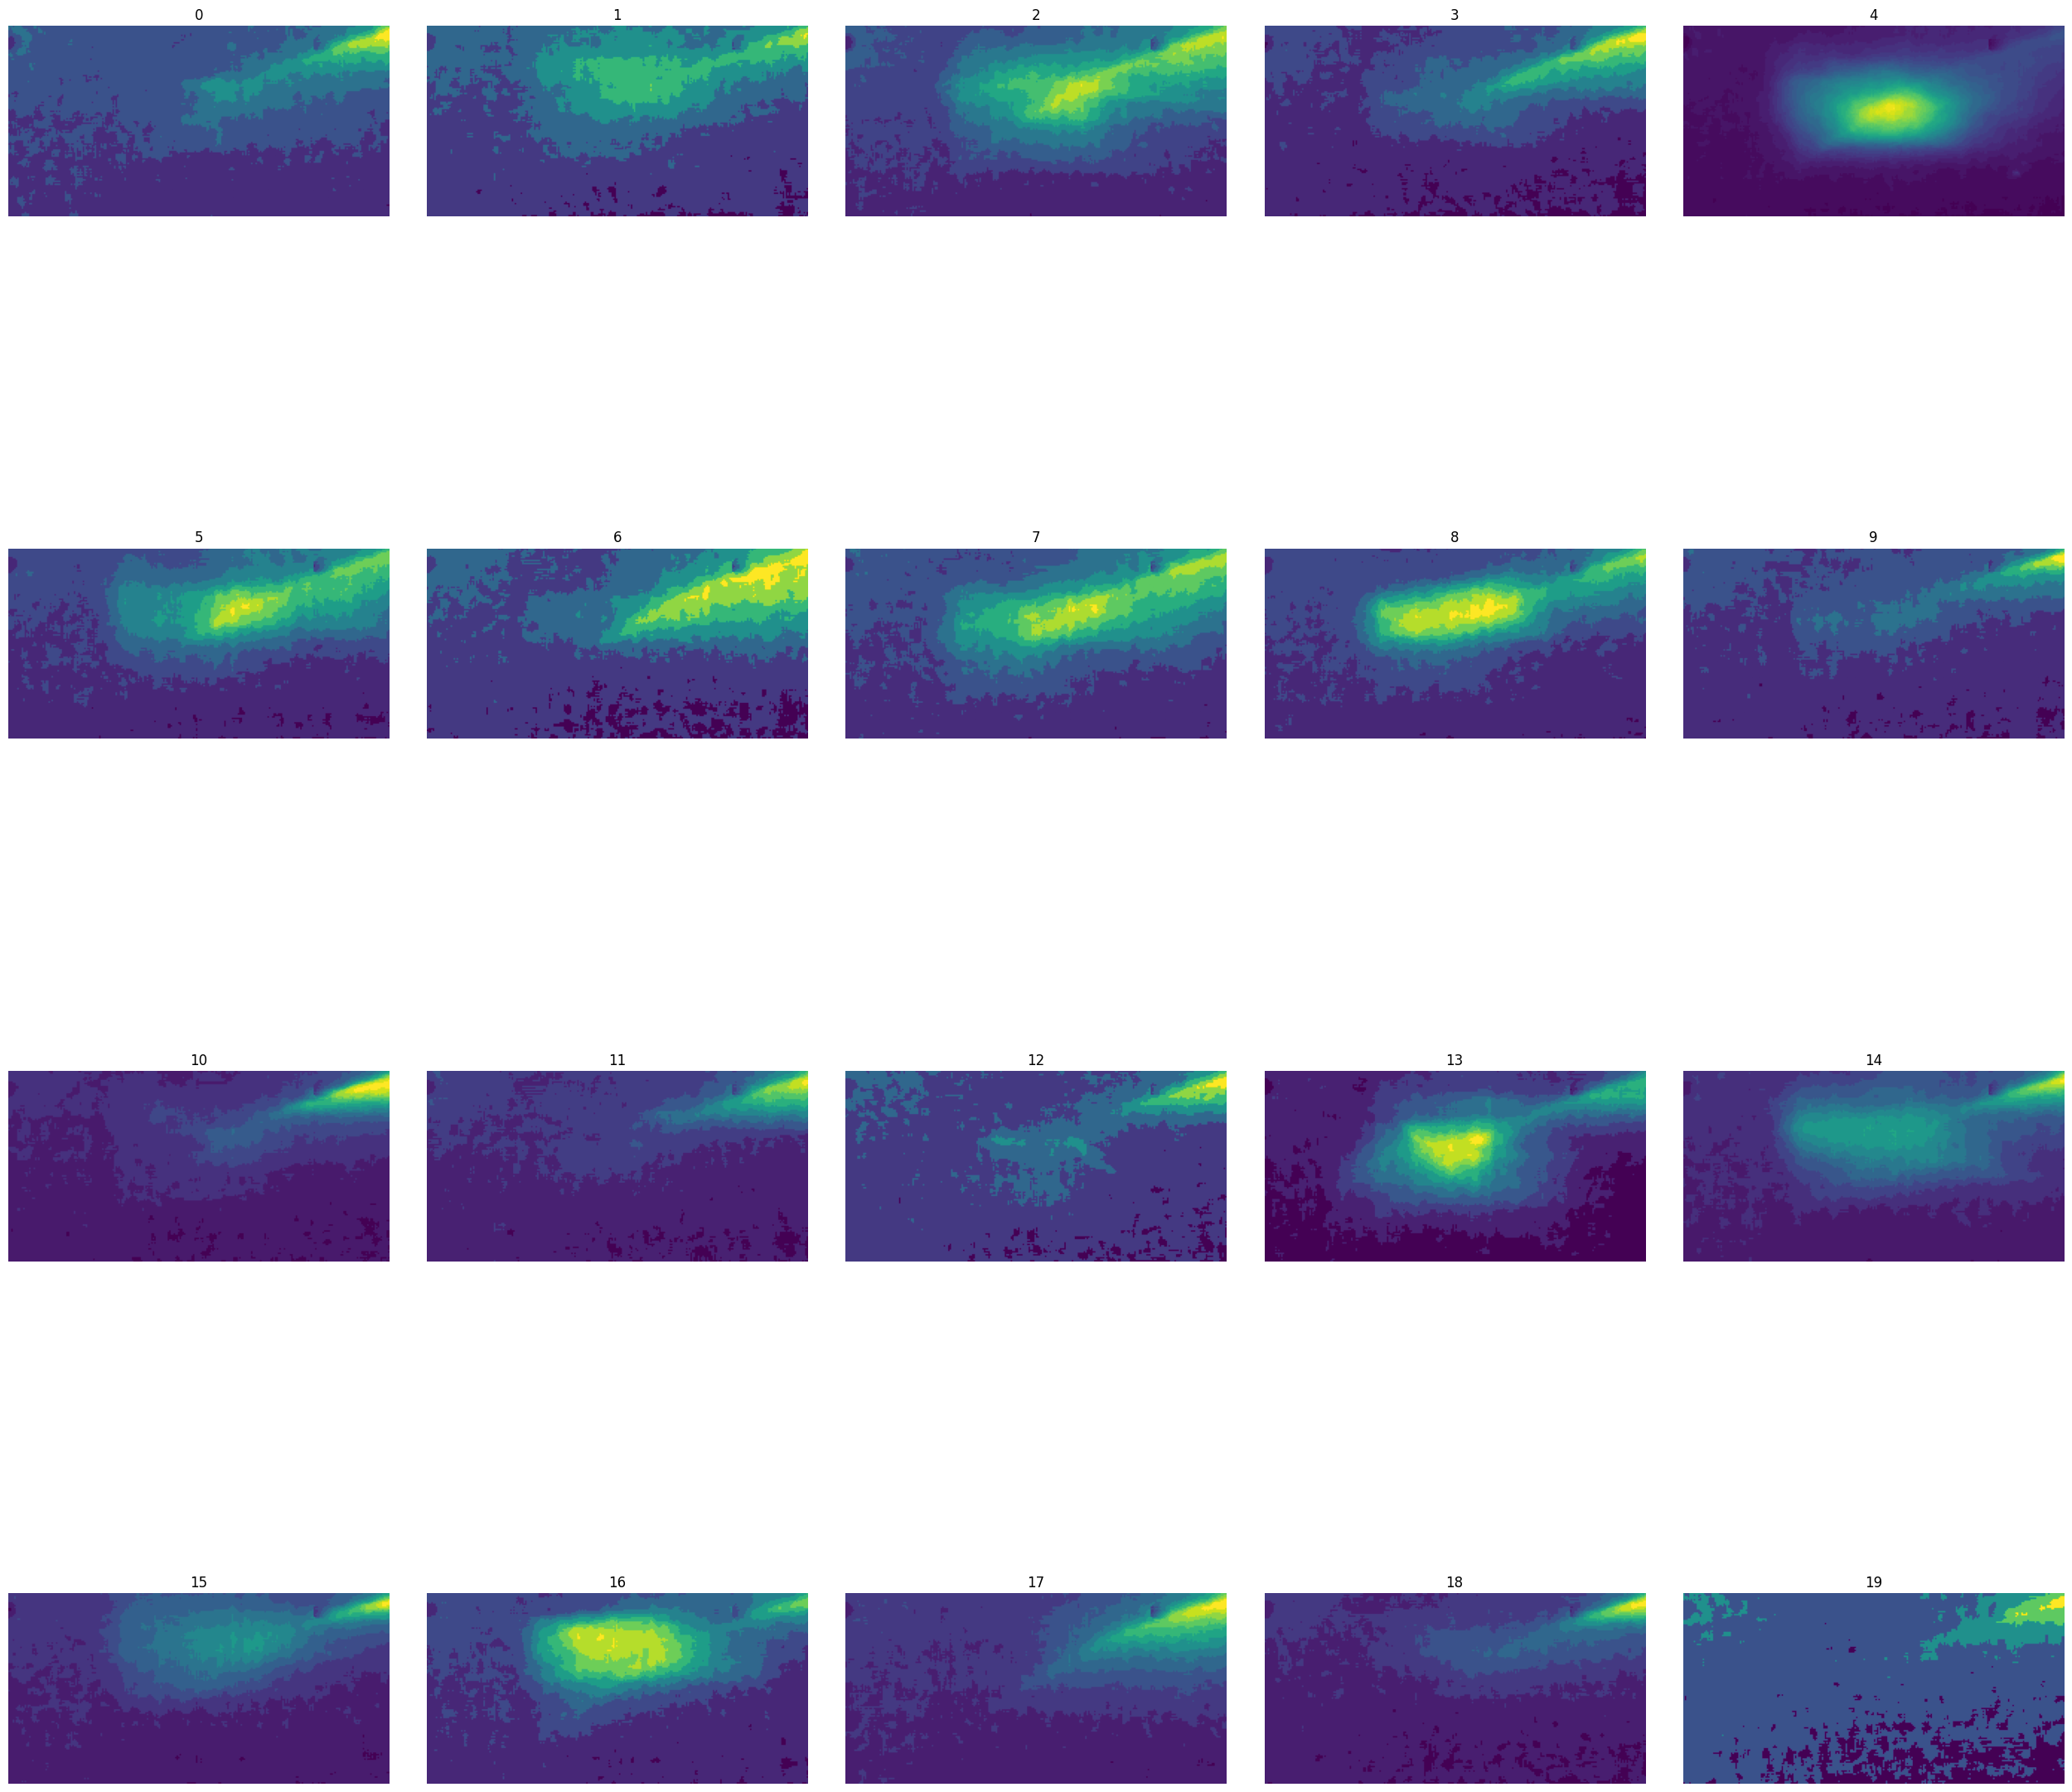

In [4]:
plot_images_from_dir("train/17", 20)